## Alternative Data exploration for Revenue prediction

###### Load dependency libraries 

In [1]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline
from pandas.io.json import json_normalize
import seaborn as sns

###### Use EODHistorical API provided to source Revenue data for BKNG.US under the Financial -> Income_Statement -> Quarterly  data dictionary keys

The API supports fields filtering with the parameter ‘filter=’. With ability to specify a block, field or Code required within the json data. Also different layers can be divided with “::” and it’s possible to have any number of layers. In our case, we want the quarterly Income_Statement and hence have configured API accordingly.

In [2]:
# Specify API url link to for quarterly income statement retrival
eodhist_url = 'http://eodhistoricaldata.com/api/fundamentals/BKNG.US?api_token=5cc0ea63d1cda3.37070012&filter=Financials::Income_Statement::quarterly'

In [3]:
#Use a combination of pandas json reader to read json data as series
#And normalise with json normaliser and finally retrive the required column fields
fund_df = json_normalize(pd.read_json(eodhist_url,typ='series'))[['date','totalRevenue','costOfRevenue']]

In [4]:
#Explore the data
print(fund_df.head())
print()
print(fund_df.info())

         date   totalRevenue costOfRevenue
0  2019-03-31  2837000000.00  501000000.00
1  2018-12-31  3212615000.00  242000000.00
2  2018-09-30  4849090000.00          0.00
3  2018-06-30  3537094000.00          0.00
4  2018-03-31  2928201000.00          0.00

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 3 columns):
date             77 non-null object
totalRevenue     77 non-null object
costOfRevenue    77 non-null object
dtypes: object(3)
memory usage: 1.9+ KB
None


In [5]:
#set date as index for later use in dataframe join operation
fund_df.index = pd.to_datetime(fund_df.date)

###### Load tweet data extracted from altcap database for BKNG.US into a dataframe and process data for senitments

In [6]:
#Load tweet data from filesystem
tweet_df = pd.read_csv('C:\\Users\\eche1\\Downloads\\tweets_bkng.csv', parse_dates = ['date'])

In [7]:
# define function to be used for tweet senitments analysis 
def clean_get_twt_sentiment(tweet): 
        ''' 
        Utility function to clean tweet text by removing links, special characters 
        using simple regex statements and to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        #clean tweet
        clean_tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(clean_tweet) 
        # set sentiment 
        if analysis.sentiment.polarity > 0: 
            return 'positive'
        elif analysis.sentiment.polarity == 0: 
            return 'neutral'
        else: 
            return 'negative'

In [8]:
#Explore tweet data 
tweet_df.head()

,date,text,likes,retweet,count_comments,ticker
0,2015-04-09 08:45:00,Q5. What activity organised by an accommodatio...,0,0,0,BKNG.O
1,2015-04-09 08:45:00,Q5. What activity organised by an accommodatio...,0,0,0,BKNG.O
2,2015-04-09 08:51:00,Q6 #BookingsBest lists are based on reviews wi...,3,1,5,BKNG.O
3,2015-04-09 08:52:00,#BookingsBest lists are based on reviews with ...,1,1,0,BKNG.O
4,2015-04-09 08:52:00,#BookingsBest lists are based on reviews with ...,0,0,0,BKNG.O


In [9]:
#Process the tweet text for senitment indicator
tweet_df['senti']  = tweet_df['text'].apply(clean_get_twt_sentiment)

In [10]:
#Explore tweet data for senitment indicator
tweet_df.head()

,date,text,likes,retweet,count_comments,ticker,senti
0,2015-04-09 08:45:00,Q5. What activity organised by an accommodatio...,0,0,0,BKNG.O,neutral
1,2015-04-09 08:45:00,Q5. What activity organised by an accommodatio...,0,0,0,BKNG.O,neutral
2,2015-04-09 08:51:00,Q6 #BookingsBest lists are based on reviews wi...,3,1,5,BKNG.O,positive
3,2015-04-09 08:52:00,#BookingsBest lists are based on reviews with ...,1,1,0,BKNG.O,positive
4,2015-04-09 08:52:00,#BookingsBest lists are based on reviews with ...,0,0,0,BKNG.O,positive


In [11]:
#set date as index for later use in dataframe time series, resampling (quarterly) and  join operations
tweet_df.index = pd.to_datetime(tweet_df.date)

In [12]:
#select required features columns and convert categorical senitment into indicator variables
tweet_df2 = pd.get_dummies(tweet_df[['likes','retweet','count_comments','senti']])

In [13]:
#Explore new data frame
tweet_df2.head()

,likes,retweet,count_comments,senti_negative,senti_neutral,senti_positive
date,,,,,,
2015-04-09 08:45:00,0,0,0,0,1,0
2015-04-09 08:45:00,0,0,0,0,1,0
2015-04-09 08:51:00,3,1,5,0,0,1
2015-04-09 08:52:00,1,1,0,0,0,1
2015-04-09 08:52:00,0,0,0,0,0,1


In [14]:
#Explore summing the individual column by date
tweet_df2.groupby([tweet_df2.index.date]).aggregate(np.sum).head()

,likes,retweet,count_comments,senti_negative,senti_neutral,senti_positive
2015-04-09,11,5,9,0,2,8
2015-04-10,20,2,0,0,0,1
2015-04-11,16,2,0,0,1,0
2015-04-12,14,5,1,0,1,0
2015-04-13,11,4,1,0,1,0


In [15]:
#Sum tweet feature values by date
tweet_sum_df = tweet_df2.groupby([tweet_df2.index.date]).aggregate(np.sum)

In [16]:
tweet_sum_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 533 entries, 2015-04-09 to 2019-05-16
Data columns (total 6 columns):
likes             533 non-null int64
retweet           533 non-null int64
count_comments    533 non-null int64
senti_negative    533 non-null uint8
senti_neutral     533 non-null uint8
senti_positive    533 non-null uint8
dtypes: int64(3), uint8(3)
memory usage: 18.2+ KB


In [17]:
#reset date as index for later use in dataframe time series, resampling (quarterly) and  join operations
tweet_sum_df.index = pd.to_datetime(tweet_sum_df.index)

In [18]:
#Explore the resampling by Quarterly and aggregation.. this should be similar to cumsun function
tweet_sum_df.resample('Q', label='right').sum()

,likes,retweet,count_comments,senti_negative,senti_neutral,senti_positive
2015-06-30,896,348,152,4,39,48
2015-09-30,263,190,139,0,10,17
2015-12-31,154,57,35,1,9,9
2016-03-31,171,85,15,0,3,3
2016-06-30,585,141,64,3,6,12
2016-09-30,1051,327,278,3,16,27
2016-12-31,556,120,45,2,7,14
2017-03-31,494,130,64,4,7,20
2017-06-30,742,183,313,2,13,47
2017-09-30,1160,250,679,9,32,82


In [19]:
# Check the Resampling and aggreggation is correct... using specific quarter date.
print(tweet_sum_df.loc[:'2015-06-30'].sum())
print()
print(tweet_sum_df.loc['2015-06-30': '2015-09-30'].sum())

likes             896
retweet           348
count_comments    152
senti_negative      4
senti_neutral      39
senti_positive     48
dtype: int64

likes             263
retweet           190
count_comments    139
senti_negative      0
senti_neutral      10
senti_positive     17
dtype: int64


In [20]:
#Resample tweet data to Quarterly to match Revenue time series
tweet_sum_quarterly_df = tweet_sum_df.resample('Q', label='right').sum()

In [21]:
#Explore data
tweet_sum_quarterly_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17 entries, 2015-06-30 to 2019-06-30
Freq: Q-DEC
Data columns (total 6 columns):
likes             17 non-null int64
retweet           17 non-null int64
count_comments    17 non-null int64
senti_negative    17 non-null uint8
senti_neutral     17 non-null uint8
senti_positive    17 non-null uint8
dtypes: int64(3), uint8(3)
memory usage: 595.0 bytes


In [22]:
#Join tweet and revenue dataframe by quarterly date
tweet_fund_df = fund_df[['totalRevenue','costOfRevenue']].join(tweet_sum_quarterly_df, how='inner')
tweet_fund_df

,totalRevenue,costOfRevenue,likes,retweet,count_comments,senti_negative,senti_neutral,senti_positive
2019-03-31,2837000000.00,501000000.00,302,53,285,2,0,11
2018-12-31,3212615000.00,242000000.00,246,66,260,0,2,8
2018-09-30,4849090000.00,0.00,344,68,385,0,2,8
2018-06-30,3537094000.00,0.00,897,112,217,5,5,50
2018-03-31,2928201000.00,0.00,1199,159,222,9,27,62
2017-12-31,2803093000.00,45150000.00,1492,303,500,8,34,105
2017-09-30,4434029000.00,54181000.00,1160,250,679,9,32,82
2017-06-30,3024556000.00,67425000.00,742,183,313,2,13,47
2017-03-31,2419404000.00,80401000.00,494,130,64,4,7,20
2016-12-31,2348433000.00,72072000.00,556,120,45,2,7,14


In [23]:
#Drop costOfRevenue as this will not be needed
tweet_fund_df.drop('costOfRevenue', axis=1, inplace=True)

In [24]:
#Normalise and standardise the data values
from sklearn import preprocessing as prep
#tweet_fund_df_nom = pd.DataFrame(prep.MinMaxScaler(feature_range=(0, 1)).fit_transform(tweet_fund_df), columns=tweet_fund_df.columns, index=tweet_fund_df.index)
tweet_fund_df_nom = pd.DataFrame(prep.StandardScaler().fit_transform(tweet_fund_df), columns=tweet_fund_df.columns, index=tweet_fund_df.index)

C:\Users\eche1\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\eche1\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [25]:
#Explore normalised dataframe
tweet_fund_df_nom

,totalRevenue,likes,retweet,count_comments,senti_negative,senti_neutral,senti_positive
2019-03-31,-0.224631,-0.886782,-1.151780,0.320742,-0.415227,-1.081182,-0.743672
2018-12-31,0.261087,-1.025690,-1.014412,0.179290,-1.079591,-0.917985,-0.846543
2018-09-30,2.377258,-0.782600,-0.993278,0.886550,-1.079591,-0.917985,-0.846543
2018-06-30,0.680680,0.589121,-0.528339,-0.064007,0.581318,-0.673189,0.593652
2018-03-31,-0.106696,1.338234,-0.031700,-0.035717,1.910046,1.121982,1.005136
2017-12-31,-0.268477,2.065023,1.489917,1.537230,1.577864,1.693173,2.479620
2017-09-30,1.840531,1.241495,0.929877,2.550026,1.910046,1.529975,1.690942
2017-06-30,0.017903,0.204642,0.221903,0.479169,-0.415227,-0.020400,0.490781
2017-03-31,-0.764636,-0.410524,-0.338137,-0.929693,0.249136,-0.509992,-0.435059
2016-12-31,-0.856410,-0.256733,-0.443805,-1.037197,-0.415227,-0.509992,-0.640801


In [26]:
#Explore correlation between Revenue and other feature values
tweet_fund_df_nom.corr()

,totalRevenue,likes,retweet,count_comments,senti_negative,senti_neutral,senti_positive
totalRevenue,1.000000,0.242425,0.089407,0.740516,0.154957,0.021636,0.215627
likes,0.242425,1.000000,0.749258,0.585070,0.884749,0.795292,0.911202
retweet,0.089407,0.749258,1.000000,0.377470,0.510280,0.836692,0.652346
count_comments,0.740516,0.585070,0.377470,1.000000,0.532460,0.462752,0.686259
senti_negative,0.154957,0.884749,0.510280,0.532460,1.000000,0.742016,0.874409
senti_neutral,0.021636,0.795292,0.836692,0.462752,0.742016,1.000000,0.822844
senti_positive,0.215627,0.911202,0.652346,0.686259,0.874409,0.822844,1.000000


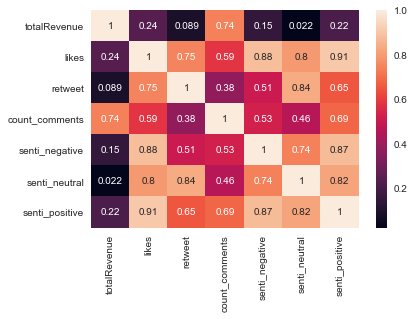

In [27]:
#Explore visual correlation between Revenue and other feature values
sns.heatmap(tweet_fund_df_nom.corr(), annot=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017B91F2D438>,
      dtype=object)

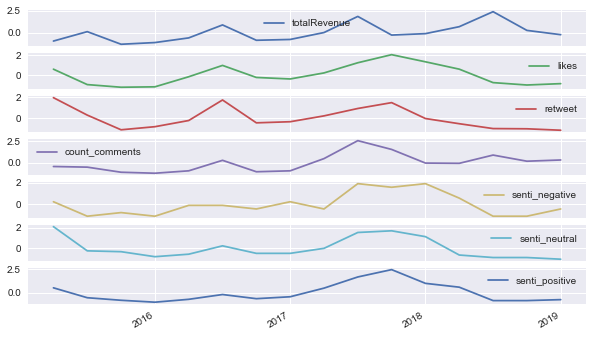

In [28]:
#Explore visual correlation between Revenue and other feature values
tweet_fund_df_nom.plot(subplots=True, figsize=(10,6))

In [29]:
#checking whether more correleration can be observed from a time shift or lag of the features with features 
#that were not originally correlated showing good signal.

feats = tweet_fund_df_nom.drop('totalRevenue', axis=1).columns.values
[ {x + '_' + str(y) : tweet_fund_df_nom[x].shift(y).corr(tweet_fund_df_nom.totalRevenue)} for x in feats for y in range(5) ]

[{'likes_0': 0.24242485925361343},
 {'likes_1': 0.1377245548605161},
 {'likes_2': -0.09931723995146831},
 {'likes_3': -0.08461449533731318},
 {'likes_4': -0.10675441759345405},
 {'retweet_0': 0.08940743062571363},
 {'retweet_1': -0.06768196380798862},
 {'retweet_2': -0.356740722273298},
 {'retweet_3': -0.40819912718815954},
 {'retweet_4': -0.07544432239596847},
 {'count_comments_0': 0.7405158540854997},
 {'count_comments_1': 0.39766299851108655},
 {'count_comments_2': -0.00035689765884525706},
 {'count_comments_3': -0.03011492658646072},
 {'count_comments_4': 0.6120657017565297},
 {'senti_negative_0': 0.1549570044879294},
 {'senti_negative_1': 0.07399691940041826},
 {'senti_negative_2': 0.12554416031877225},
 {'senti_negative_3': -0.02160128308349073},
 {'senti_negative_4': -0.14305887708002446},
 {'senti_neutral_0': 0.021635929529872634},
 {'senti_neutral_1': 0.1259903230858425},
 {'senti_neutral_2': -0.1028306947411578},
 {'senti_neutral_3': -0.30682796770003956},
 {'senti_neutral_4'

###### Prepare data for using in Stats and Machine Learning Models

In [30]:
# Select target(dependent/label) and feature(independent) variables
targets = tweet_fund_df_nom['totalRevenue']
features = tweet_fund_df_nom.drop(['totalRevenue'], axis=1)
feature_names = features.columns
feature_names = features.columns
features.shape, targets.shape

((16, 6), (16,))

In [31]:
# Using a linear OLS model here 
import statsmodels.api as sm

In [32]:
# Add a constant to the features
linear_features = sm.add_constant(features)

In [33]:
#Explore features columns
linear_features.columns

Index(['const', 'likes', 'retweet', 'count_comments', 'senti_negative',
       'senti_neutral', 'senti_positive'],
      dtype='object')

In [34]:
# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * targets.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

(16, 7) (13, 7) (3, 7)


In [35]:
# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           totalRevenue   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     4.701
Date:                Mon, 17 Jun 2019   Prob (F-statistic):             0.0408
Time:                        00:40:04   Log-Likelihood:                -7.1495
No. Observations:                  13   AIC:                             28.30
Df Residuals:                       6   BIC:                             32.25
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.2129      0.217     -0.

C:\Users\eche1\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))


In [36]:
# Examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

const             0.365398
likes             0.111865
retweet           0.384302
count_comments    0.002289
senti_negative    0.891617
senti_neutral     0.634358
senti_positive    0.069440
dtype: float64


In [37]:
# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

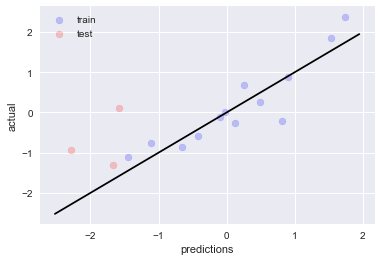

In [38]:
# Scatter the predictions vs the targets with 80% transparency
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

In [39]:
# Try with Random Forest
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.8384643116951802
-1.6848653996684244


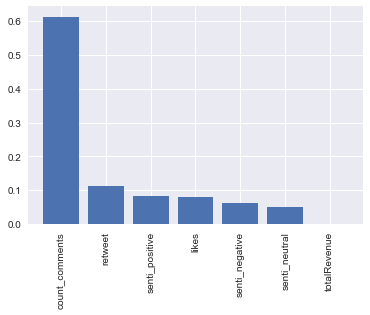

In [40]:
# Get feature importances from our random forest model
importances = rfr.feature_importances_

#importances = importances[1:]

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(tweet_fund_df_nom.columns.values)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

In [41]:
#try out gradient boosting model
from sklearn.ensemble import GradientBoostingRegressor

# Create GB model -- hyperparameters have already been searched for you
gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)
gbr.fit(train_features, train_targets)


print(gbr.score(train_features, train_targets))
print(gbr.score(test_features, test_targets))

0.8070233126623585
-1.6743921181243215


In [42]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
# Instantiate the XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(seed=123, objective='reg:linear', max_depth=10)

# Fit the regressor to the training set
xg_reg.fit(train_features, train_targets)

# Predict the labels of the test set: preds
preds = xg_reg.predict(test_features)

# Compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(test_targets, preds))
print("RMSE: %f" % (rmse))


print(xg_reg.score(train_features, train_targets))
print(xg_reg.score(test_features, test_targets))

RMSE: 1.174823
0.999981440932979
-2.7679015038715566


C:\Users\eche1\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\eche1\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


##### WebTraffic Analysis with Revenue data

In [43]:
#Load web traffic data extract from altcap database
web_traf = pd.read_csv('C:\\Users\\eche1\\Downloads\\BKNG_webtraffic.csv', parse_dates = ['date'])

In [44]:
#Explore data
print(web_traf.head())
print()
print(web_traf.info())

        date  traffic  paid_traffic
0 2012-01-15   339352        429520
1 2012-02-15   305865        492690
2 2012-03-15   261274        481117
3 2012-04-15   354461        472161
4 2012-05-15   348095        344127

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
date            87 non-null datetime64[ns]
traffic         87 non-null int64
paid_traffic    87 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.1 KB
None


In [45]:
#set date as index for later use in dataframe time series, resampling (quarterly) and  join operations
web_traf.index = pd.to_datetime(web_traf.date)

In [46]:
#Resample the data fram to Quarterly to match the revenue data time series
web_traf_quarterly = web_traf.resample('Q', label='right').sum()

In [47]:
#Explore data
print(web_traf_quarterly.head())
print()
print(web_traf_quarterly.info())

            traffic  paid_traffic
date                             
2012-03-31   906491       1403327
2012-06-30   938977       1203557
2012-09-30  1049085        603426
2012-12-31  1374946       1213900
2013-03-31  1795384       1564678

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29 entries, 2012-03-31 to 2019-03-31
Freq: Q-DEC
Data columns (total 2 columns):
traffic         29 non-null int64
paid_traffic    29 non-null int64
dtypes: int64(2)
memory usage: 696.0 bytes
None


In [48]:
#Join web traffic and revenue dataframe by quarterly date
#webtraffic_fund_df =  fund_df[['totalRevenue','costOfRevenue']].join(web_traf_quarterly,how='inner')
webtraffic_fund_df = fund_df[['totalRevenue']].join(web_traf_quarterly,how='inner')

In [49]:
#Explore data
print(webtraffic_fund_df.head())
print()
print(webtraffic_fund_df.info())

             totalRevenue   traffic  paid_traffic
date                                             
2019-03-31  2837000000.00  41952583     292987022
2018-12-31  3212615000.00  43465557     197796997
2018-09-30  4849090000.00  39868199      85293585
2018-06-30  3537094000.00  43277687      16451079
2018-03-31  2928201000.00  42974170      15235298

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29 entries, 2019-03-31 to 2012-03-31
Freq: -1Q-DEC
Data columns (total 3 columns):
totalRevenue    29 non-null object
traffic         29 non-null int64
paid_traffic    29 non-null int64
dtypes: int64(2), object(1)
memory usage: 928.0+ bytes
None


In [50]:
#Standardise and normalise datafram values
from sklearn import preprocessing as prep
#tweet_fund_df_nom = pd.DataFrame(prep.MinMaxScaler(feature_range=(0, 1)).fit_transform(tweet_fund_df), columns=tweet_fund_df.columns, index=tweet_fund_df.index)
webtraffic_fund_df_nom = pd.DataFrame(prep.StandardScaler().fit_transform(webtraffic_fund_df), columns=webtraffic_fund_df.columns, index=webtraffic_fund_df.index)

C:\Users\eche1\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\eche1\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [51]:
#Explore standardise dataframe
webtraffic_fund_df_nom.head()

,totalRevenue,traffic,paid_traffic
date,,,
2019-03-31,0.442211,1.860641,4.240993
2018-12-31,0.851651,1.963628,2.736939
2018-09-30,2.635494,1.718759,0.959324
2018-06-30,1.205350,1.950840,-0.128425
2018-03-31,0.541625,1.930180,-0.147635


In [52]:
#Explore correlation between Revenue and other feature values
webtraffic_fund_df_nom.corr()

,totalRevenue,traffic,paid_traffic
totalRevenue,1.000000,0.725199,0.321129
traffic,0.725199,1.000000,0.626429
paid_traffic,0.321129,0.626429,1.000000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017B96241518>,
      dtype=object)

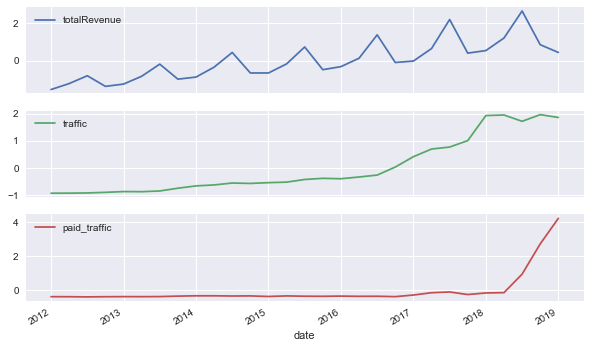

In [53]:
#Explore visual correlation between Revenue and other feature values
webtraffic_fund_df_nom.plot(subplots=True,figsize=(10,6))

In [54]:
#Any correlation by shifting or lagging the time series data?
feats = webtraffic_fund_df_nom.drop('totalRevenue', axis=1).columns.values
[ {x + '_' + str(y) : webtraffic_fund_df_nom[x].shift(y).corr(webtraffic_fund_df_nom.totalRevenue)} for x in feats for y in range(5) ]

[{'traffic_0': 0.7251990769072048},
 {'traffic_1': 0.7578193971300717},
 {'traffic_2': 0.8070296948415889},
 {'traffic_3': 0.7833742197780313},
 {'traffic_4': 0.710161961990801},
 {'paid_traffic_0': 0.32112942442565384},
 {'paid_traffic_1': 0.4997085398623814},
 {'paid_traffic_2': 0.6246249703818663},
 {'paid_traffic_3': 0.4193649061391939},
 {'paid_traffic_4': 0.3963421842676794}]

###### Prepare data for Stats and Machine Learning models

In [55]:
# Select target(dependent/label) and feature(independent) variables
targets = webtraffic_fund_df_nom['totalRevenue']
features = webtraffic_fund_df_nom.drop(['totalRevenue'], axis=1)
feature_names = features.columns
features.shape, targets.shape

((29, 2), (29,))

In [56]:
# Using a linear OLS model here 
import statsmodels.api as sm
# Add a constant to the features
linear_features = sm.add_constant(features)
linear_features.columns

Index(['const', 'traffic', 'paid_traffic'], dtype='object')

In [57]:
# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * targets.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

(29, 3) (24, 3) (5, 3)


In [58]:
# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           totalRevenue   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     8.947
Date:                Mon, 17 Jun 2019   Prob (F-statistic):            0.00155
Time:                        00:40:06   Log-Likelihood:                -24.304
No. Observations:                  24   AIC:                             54.61
Df Residuals:                      21   BIC:                             58.14
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1316      0.148      0.888   

In [59]:
# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

const           0.384545
traffic         0.000922
paid_traffic    0.317671
dtype: float64


In [60]:
# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

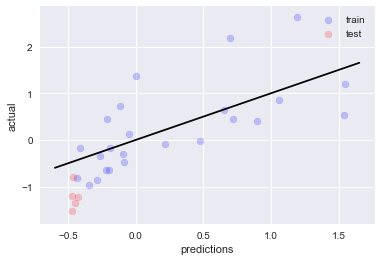

In [61]:
# Scatter the predictions vs the targets with 80% transparency
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

In [62]:
## trying Decision Tree Models
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
decision_tree = DecisionTreeRegressor()

# Fit the model to the training features and targets
decision_tree.fit(train_features, train_targets)

# Check the score on train and test
print(decision_tree.score(train_features, train_targets))
print(decision_tree.score(test_features, test_targets))

1.0
-2.747050776207829


In [63]:
# Try with Random Forest
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.9111840523724524
-4.748078787147845


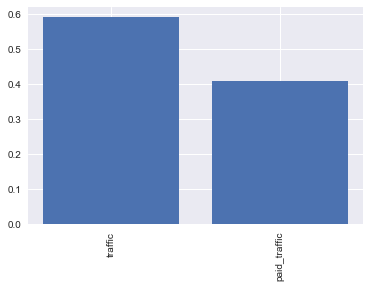

In [64]:
# Get feature importances from our random forest model
importances = rfr.feature_importances_

importances = importances[1:]

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

In [65]:
#try out gradient boosting model
from sklearn.ensemble import GradientBoostingRegressor

# Create GB model -- hyperparameters have already been searched for you
gbr = GradientBoostingRegressor(learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)
gbr.fit(train_features, train_targets)

print(gbr.score(train_features, train_targets))
print(gbr.score(test_features, test_targets))

0.8847358086224316
-7.679102696026689


### Combine alternative data from Webtraffic and Twitter

In [66]:
#Review tweet and revenue data frame
tweet_fund_df

,totalRevenue,likes,retweet,count_comments,senti_negative,senti_neutral,senti_positive
2019-03-31,2837000000.00,302,53,285,2,0,11
2018-12-31,3212615000.00,246,66,260,0,2,8
2018-09-30,4849090000.00,344,68,385,0,2,8
2018-06-30,3537094000.00,897,112,217,5,5,50
2018-03-31,2928201000.00,1199,159,222,9,27,62
2017-12-31,2803093000.00,1492,303,500,8,34,105
2017-09-30,4434029000.00,1160,250,679,9,32,82
2017-06-30,3024556000.00,742,183,313,2,13,47
2017-03-31,2419404000.00,494,130,64,4,7,20
2016-12-31,2348433000.00,556,120,45,2,7,14


In [67]:
#Review web traffic and revenue data frame
webtraffic_fund_df

,totalRevenue,traffic,paid_traffic
date,,,
2019-03-31,2837000000.00,41952583,292987022
2018-12-31,3212615000.00,43465557,197796997
2018-09-30,4849090000.00,39868199,85293585
2018-06-30,3537094000.00,43277687,16451079
2018-03-31,2928201000.00,42974170,15235298
2017-12-31,2803093000.00,29406354,9355158
2017-09-30,4434029000.00,25912258,18947528
2017-06-30,3024556000.00,24841279,16137900
2017-03-31,2419404000.00,20686396,7537993


In [68]:
#Explore joining tweet_fund_df to webtraffic_fund_df  
webtraffic_fund_df[['traffic','paid_traffic']].join(tweet_fund_df,how='inner')

,traffic,paid_traffic,totalRevenue,likes,retweet,count_comments,senti_negative,senti_neutral,senti_positive
2019-03-31,41952583,292987022,2837000000.00,302,53,285,2,0,11
2018-12-31,43465557,197796997,3212615000.00,246,66,260,0,2,8
2018-09-30,39868199,85293585,4849090000.00,344,68,385,0,2,8
2018-06-30,43277687,16451079,3537094000.00,897,112,217,5,5,50
2018-03-31,42974170,15235298,2928201000.00,1199,159,222,9,27,62
2017-12-31,29406354,9355158,2803093000.00,1492,303,500,8,34,105
2017-09-30,25912258,18947528,4434029000.00,1160,250,679,9,32,82
2017-06-30,24841279,16137900,3024556000.00,742,183,313,2,13,47
2017-03-31,20686396,7537993,2419404000.00,494,130,64,4,7,20
2016-12-31,15091975,1480949,2348433000.00,556,120,45,2,7,14


In [69]:
#Combine tweet_fund_df to webtraffic_fund_df 
webtraffic_tweet_fund_df =  webtraffic_fund_df[['traffic','paid_traffic']].join(tweet_fund_df,how='inner')

In [70]:
#Standardise and normalise dataframe values
from sklearn import preprocessing as prep
#tweet_fund_df_nom = pd.DataFrame(prep.MinMaxScaler(feature_range=(0, 1)).fit_transform(tweet_fund_df), columns=tweet_fund_df.columns, index=tweet_fund_df.index)
webtraffic_tweet_fund_df_nom = pd.DataFrame(prep.StandardScaler().fit_transform(webtraffic_tweet_fund_df), columns=webtraffic_tweet_fund_df.columns, index=webtraffic_tweet_fund_df.index)

C:\Users\eche1\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\eche1\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [71]:
#Explore data
webtraffic_tweet_fund_df_nom

,traffic,paid_traffic,totalRevenue,likes,retweet,count_comments,senti_negative,senti_neutral,senti_positive
2019-03-31,1.286393,3.097198,-0.224631,-0.886782,-1.151780,0.320742,-0.415227,-1.081182,-0.743672
2018-12-31,1.393636,1.920023,0.261087,-1.025690,-1.014412,0.179290,-1.079591,-0.917985,-0.846543
2018-09-30,1.138647,0.528741,2.377258,-0.782600,-0.993278,0.886550,-1.079591,-0.917985,-0.846543
2018-06-30,1.380319,-0.322606,0.680680,0.589121,-0.528339,-0.064007,0.581318,-0.673189,0.593652
2018-03-31,1.358805,-0.337641,-0.106696,1.338234,-0.031700,-0.035717,1.910046,1.121982,1.005136
2017-12-31,0.397090,-0.410358,-0.268477,2.065023,1.489917,1.537230,1.577864,1.693173,2.479620
2017-09-30,0.149421,-0.291733,1.840531,1.241495,0.929877,2.550026,1.910046,1.529975,1.690942
2017-06-30,0.073507,-0.326479,0.017903,0.204642,0.221903,0.479169,-0.415227,-0.020400,0.490781
2017-03-31,-0.221000,-0.432830,-0.764636,-0.410524,-0.338137,-0.929693,0.249136,-0.509992,-0.435059
2016-12-31,-0.617544,-0.507735,-0.856410,-0.256733,-0.443805,-1.037197,-0.415227,-0.509992,-0.640801


In [72]:
#Explore correlaration between Revenue and features
webtraffic_tweet_fund_df_nom.corr()

,traffic,paid_traffic,totalRevenue,likes,retweet,count_comments,senti_negative,senti_neutral,senti_positive
traffic,1.000000,0.600971,0.486424,0.169449,-0.358751,0.474140,0.262173,-0.148611,0.227598
paid_traffic,0.600971,1.000000,0.165000,-0.357652,-0.457775,0.195441,-0.271918,-0.407725,-0.294768
totalRevenue,0.486424,0.165000,1.000000,0.242425,0.089407,0.740516,0.154957,0.021636,0.215627
likes,0.169449,-0.357652,0.242425,1.000000,0.749258,0.585070,0.884749,0.795292,0.911202
retweet,-0.358751,-0.457775,0.089407,0.749258,1.000000,0.377470,0.510280,0.836692,0.652346
count_comments,0.474140,0.195441,0.740516,0.585070,0.377470,1.000000,0.532460,0.462752,0.686259
senti_negative,0.262173,-0.271918,0.154957,0.884749,0.510280,0.532460,1.000000,0.742016,0.874409
senti_neutral,-0.148611,-0.407725,0.021636,0.795292,0.836692,0.462752,0.742016,1.000000,0.822844
senti_positive,0.227598,-0.294768,0.215627,0.911202,0.652346,0.686259,0.874409,0.822844,1.000000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017B964EA2B0>,
      dtype=object)

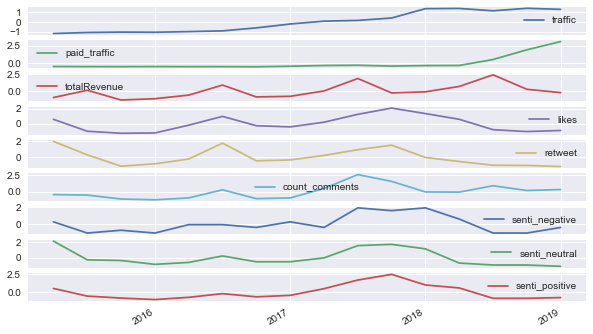

In [73]:
webtraffic_tweet_fund_df_nom.plot(subplots=True, figsize=(10,6))

###### Prepare data for Stats and Machine Learning models

In [74]:
# Select target(dependent/label) and feature(independent) variables
targets = webtraffic_tweet_fund_df_nom['totalRevenue']
features = webtraffic_tweet_fund_df_nom.drop(['totalRevenue'], axis=1)
feature_names = features.columns
features.shape, targets.shape

((16, 8), (16,))

In [75]:
# Using a linear OLS model here 
import statsmodels.api as sm
# Add a constant to the features
linear_features = sm.add_constant(features)
linear_features.columns

Index(['const', 'traffic', 'paid_traffic', 'likes', 'retweet',
       'count_comments', 'senti_negative', 'senti_neutral', 'senti_positive'],
      dtype='object')

In [76]:
# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * targets.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

(16, 9) (13, 9) (3, 9)


In [77]:
# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           totalRevenue   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     111.7
Date:                Mon, 17 Jun 2019   Prob (F-statistic):           0.000197
Time:                        00:40:09   Log-Likelihood:                 16.722
No. Observations:                  13   AIC:                            -15.44
Df Residuals:                       4   BIC:                            -10.36
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.1958      0.045     -4.

C:\Users\eche1\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))


In [78]:
# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

const             0.012337
traffic           0.007764
paid_traffic      0.000284
likes             0.063336
retweet           0.971779
count_comments    0.000029
senti_negative    0.101496
senti_neutral     0.017243
senti_positive    0.000236
dtype: float64


In [79]:
# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

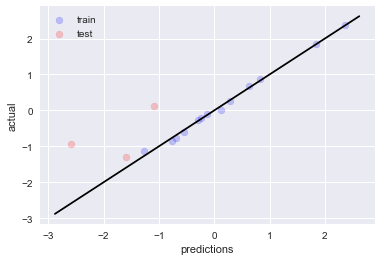

In [80]:
# Scatter the predictions vs the targets with 80% transparency
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

In [81]:
## trying Decision Tree Models
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
decision_tree = DecisionTreeRegressor()

# Fit the model to the training features and targets
decision_tree.fit(train_features, train_targets)

# Check the score on train and test
print(decision_tree.score(train_features, train_targets))
print(decision_tree.score(test_features, test_targets))

1.0
-2.921474529396102


In [82]:
# Try with Random Forest
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.8580535745035016
-1.2073638174918648


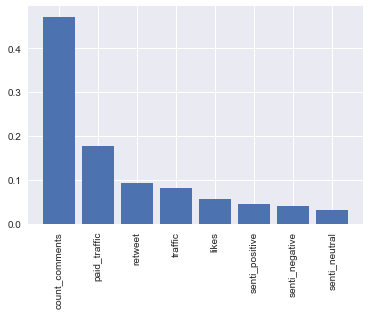

In [83]:
# Get feature importances from our random forest model
importances = rfr.feature_importances_

importances = importances[1:]

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()